In [1]:
# Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm as tqdm

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Dataset class for MNIST
class MNIST_Dataset(Dataset):
    
    def __init__(self, train=True, transform=T.ToTensor()):
        if train:
            self.data = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
            self.y = self.data['label']
            self.data = self.data.drop(['label'], axis=1)
        else:
            self.data = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')
            self.y = self.data['label'] #torch.tensor(self.data['label'].values).to(device)
            self.data = self.data.drop(['label'], axis=1) #torch.tensor(self.data.drop(['label'], axis=1).values).to(device)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = np.array(self.data.iloc[index], dtype=np.float32) # float32 in order to be converted to float with ToTensor() instead of double
        img = img.reshape(28, 28, 1)
        img = img / 255 # Normalization
        if self.transform:
            img = self.transform(img)
            
        if self.y is not None:
            return (img, self.y[index]) # (X, Y)
        else:
            return img # Only X

In [4]:
# Splitting X_train into traning and validation sets
train_dataset = MNIST_Dataset(train=True)
# val_split = 2e-1
# len_val_set = int(len(full_train_set)*val_split)
# len_train_set = len(full_train_set) - len_val_set 
# train_dataset, val_dataset = random_split(full_train_set, (len_train_set, len_val_set))

# Test set
test_dataset = MNIST_Dataset(train=False)

# Details
print(f'Total nb of train imgs: {len(train_dataset)}')
# print(f"Total nb of validation imgs: {len(val_dataset)}")
print(f"Total nb of test imgs: {len(test_dataset)}")

Total nb of train imgs: 60000
Total nb of test imgs: 10000


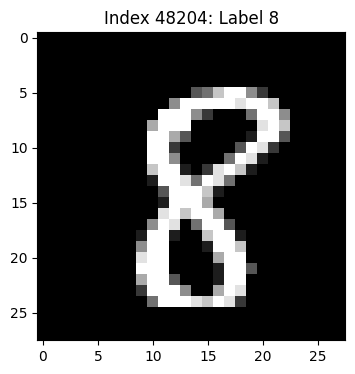

In [5]:
# Showing an img from train set at random
fig, ax = plt.subplots(1, 1, figsize=(8,4))
idx = np.random.choice(np.arange(len(train_dataset)))
img, label = train_dataset[idx]
ax.set(title=f'Index {idx}: Label {label}')
ax.imshow(img.squeeze(),cmap = 'gray');

In [6]:
# Our CNN
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(self.maxpool2d(self.conv1(x)))
        x = F.relu(self.maxpool2d(self.conv2_drop(self.conv2(x))))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
# CNN instance
cnn = CNN()
cnn.to(device)
cnn

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
%%capture
!pip install torchsummary

In [8]:
from torchsummary import summary
summary(cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         Dropout2d-4             [-1, 20, 8, 8]               0
         MaxPool2d-5             [-1, 20, 4, 4]               0
            Linear-6                   [-1, 50]          16,050
            Linear-7                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.08
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


## Data loader
***

In [9]:
# Creating batches generator
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# First Batch
dataiter = iter(train_loader)
imgs, labels = next(dataiter)

print('Shape of loading one batch: {}'.format(imgs.shape))
print('Total nb of batches created in Train loader: {}'.format(len(train_loader)))
# print('Total nb of batches created in Valid loader: {}'.format(len(val_loader)))

Shape of loading one batch: torch.Size([64, 1, 28, 28])
Total nb of batches created in Train loader: 938


In [10]:
# Optim parameters
criterion = nn.CrossEntropyLoss()
# log_softmax in output activation + nn.NLLLoss() =  nn.CrossEntropyLoss() !
optimizer = optim.AdamW(cnn.parameters(), lr=1e-2)

## Training and evalutation
***

In [11]:
# Function used in order to compute the accuracy for each batch
def multiclass_accuracy(y_pred, y_true):
    top_pred, y_pred_class = y_pred.topk(1, dim = 1)
    equals = (y_pred_class == y_true.view(*y_pred_class.shape))
    return torch.mean(equals.type(torch.FloatTensor))

In [12]:
# Training loop

# Number of epochs
epochs = 15

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for i in tqdm(range(epochs), 'Epochs'):

    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # Train on each batch
    cnn.train()
    for X_batch, label_batch in train_loader:
        X_batch, label_batch = X_batch.to(device), label_batch.to(device)
        logpreds = cnn(X_batch)

        loss = criterion(logpreds, label_batch)
        optimizer.zero_grad()
        loss.backward() # dw, db
        optimizer.step() # w = w - lr*dw
        train_loss += loss.item()

        preds = torch.exp(logpreds)
        train_acc += multiclass_accuracy(preds, label_batch)

    # Evaluation for each batch
#     cnn.eval() # Dropout, Batch Norm
#     for X_batch, label_batch in val_loader:
#         X_batch, label_batch = X_batch.to(device), label_batch.to(device)
#         logpreds = cnn(X_batch)

#         loss = criterion(logpreds, label_batch)
#         val_loss += loss.item()

#         preds = torch.exp(logpreds)
#         val_acc += multiclass_accuracy(preds, label_batch)

    # Aggregate the loss for the current epoch
    avg_train_loss = train_loss/len(train_loader)
    avg_train_acc = train_acc/len(train_loader)
#     avg_val_loss = val_loss/len(val_loader)
#     avg_val_acc = val_acc/len(val_loader)

    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
#     val_losses.append(avg_val_loss)
#     val_accs.append(avg_val_acc)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
# Test set predictions
cnn.eval() # Dropout, Batch Norm
# test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)))
# print(test[0],test[1])
# logpreds = cnn(test[0].to(device))
# preds = torch.exp(logpreds) # Probabilities 
# _, y_pred = preds.topk(1, dim = 1)
# print(y_pred)
# y_pred = pd.DataFrame({'ImageId': np.arange(1, len(test_dataset)+1), 'Label': y_pred.cpu().numpy().squeeze()})
# y_pred.to_csv('submission.csv', index=False)

testloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
pred = []
for data in tqdm(testloader):
    logpreds = cnn(data[0].to(device))
    preds = torch.exp(logpreds) # Probabilities 
    _, y_pred = preds.topk(1, dim = 1)
    pred.extend(y_pred)
# print(pred.shape)
#     print(y_pred)
print(test_dataset.y[0:10])
print(list(y_pred[0:10].tolist()))
pred = [i[0] for i in y_pred.tolist()]
print(pred[0:10])

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

print('f1: ', f1_score(pred, test_dataset.y, average='macro'))
print('precision: ', precision_score(pred, test_dataset.y, average='macro'))
print('recall: ', recall_score(pred, test_dataset.y, average='macro'))
cf_matrix = confusion_matrix(pred, test_dataset.y)
cf_matrix

  0%|          | 0/1 [00:00<?, ?it/s]

0    7
1    2
2    1
3    0
4    4
5    1
6    4
7    9
8    5
9    9
Name: label, dtype: int64
[[7], [2], [1], [0], [4], [1], [4], [9], [5], [9]]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


f1:  0.9809415971501025
precision:  0.980821056748322
recall:  0.9811354179297508


array([[ 963,    0,    1,    0,    0,    1,    6,    0,    4,    1],
       [   1, 1130,    8,    0,    0,    1,    2,    5,    1,    2],
       [   3,    1, 1012,    1,    1,    0,    1,    9,    7,    2],
       [   0,    1,    6, 1003,    0,    7,    0,    2,    7,    1],
       [   2,    0,    0,    0,  951,    0,    4,    0,    3,    5],
       [   0,    0,    0,    3,    0,  880,    2,    2,    3,    7],
       [   7,    1,    0,    0,    1,    1,  941,    0,    1,    0],
       [   0,    1,    5,    2,    0,    0,    0, 1005,    1,    5],
       [   2,    1,    0,    1,    1,    1,    2,    0,  943,    4],
       [   2,    0,    0,    0,   28,    1,    0,    5,    4,  982]])